# Let's use our pipeline to preprocess our raw data, first without embedding/vectorization to check out the results

In [21]:
%load_ext autoreload 
%autoreload 2

# imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# import and instanciate config file to get access to paths
os.chdir(os.path.dirname(os.getcwd()))
from config.config import Config
config = Config()

# import utils functions
from src.pipelines.preprocessor import Preprocessor
from src.pipelines.preproc.pipeline_02 import build_preprocessor_pipeline_02
from sklearn import set_config; set_config(display='diagram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
df_init = pd.read_csv(config.DATA_PROCESSED_PATH + 'books_processed.csv')
df_init

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/books_processed.csv'

In [23]:
# verify that we have only our 10 authors
df_init['Author'].value_counts()

Author
Shakespeare William                    160
Twain Mark                             115
Dickens Charles                         47
Tolstoy Leo graf                        28
Plato                                   27
Wilde Oscar                             19
Montgomery L. M. (Lucy Maud)            12
Homer                                   12
Austen Jane                             12
Fitzgerald F. Scott (Francis Scott)      4
Name: count, dtype: int64

In [24]:
preprocessor = Preprocessor()
pipeline = build_preprocessor_pipeline_02()
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text_pipeline',
                                                  Pipeline(steps=[('body',
                                                                   FunctionTransformer(func=<bound method Preprocessor.body_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x29f8d5e10>>)),
                                                                  ('clean_body',
                                                                   FunctionTransformer(func=<bound method Preprocessor.clean_body_preprocessor of <src.pipelines.pre...
                                                                   FunctionTransformer(func=<bound method Preprocessor.encode_label_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x29f8d5e10>>))]),
                                                  ['Author'])])),
                ('functiontransformer-1',
                 FunctionTransformer(func=<bound method Preprocessor.chunk_text_preprocessor_nd of <src.pipelines.preprocessor.Preprocessor object at 0x29f8d5e10>>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<bound method Preprocessor.padding_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x29f8d5e10>>))])

In [25]:
# let's run our pipeline on our dataframe
df = pipeline.fit_transform(df_init)

In [26]:
df['Book'].apply(len)

0        3373
1        3373
2        3373
3        3373
4        3373
         ... 
92892    3373
92893    3373
92894    3373
92895    3373
92896    3373
Name: Book, Length: 92897, dtype: int64

In [27]:
df.shape

(92897, 2)

## We performed a disaggregation from a 436 rows representing each a book, to 92k rows representing each a book's chunk

### But we need to balance our dataset so we'll align with the minority class

In [28]:
# verify distribution of chunks per author
df['Author'].value_counts().head(10)

Author
6    23110
8    22667
1    15573
7     8485
5     5851
3     5747
0     3957
4     3871
9     2626
2     1010
Name: count, dtype: int64

<Axes: xlabel='Author', ylabel='count'>

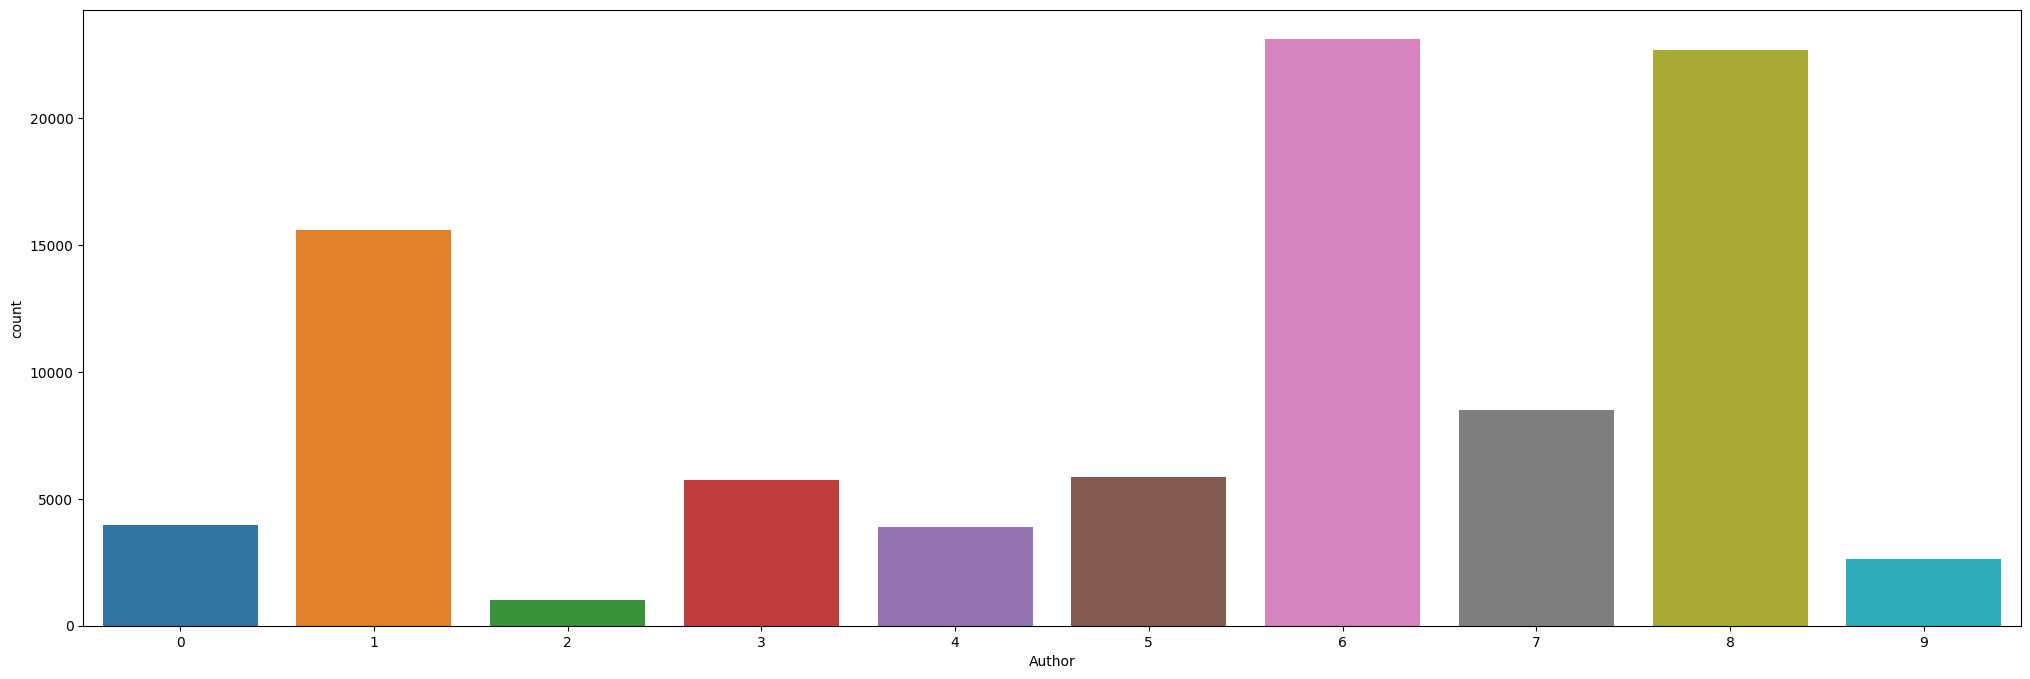

In [29]:
plt.figure(figsize=(25,8))
sns.barplot(x=df['Author'].value_counts().index, y=df['Author'].value_counts())


In [30]:
# Limit the number of chunks per author to 1000 with shuffle and random_state

df = df.groupby('Author').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)
df['Author'].value_counts()

Author
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64

In [31]:
df

# save df to csv 
# df.to_csv(os.path.join(config.DATA_FINAL_PATH + 'books_processed_pipe02.csv'), index=False)

,Author,Book
0,0,"been total silence among them for some time, h..."
1,0,"and pleasing behaviour on each side, he was ex..."
2,0,"her maintenance. as far as walking, talking, a..."
3,0,that he did not do himself; though i am sure (...
4,0,"﻿the project gutenberg ebook, pride and prejud..."
...,...,...
9995,9,"with a beautiful girl who acts juliet, and pro..."
9996,9,"and the shopkeepers' daughters, who want to be..."
9997,9,in the mouth. it was certainly curious. he tur...
9998,9,place his white hands beside the coarse bloate...


In [41]:
# number of characters per chunk
df['Book'].apply(len) # 3373 x 1000 

# number of words per chunk
df['Book'].apply(lambda x: len(x.split(' '))) # 256 x 1000 

0       256
1       256
2       256
3       256
4       256
       ... 
9995    256
9996    256
9997    256
9998    256
9999    256
Name: Book, Length: 10000, dtype: int64

# Now let's try adding word2vec embedding to our pipeline and do the same again. 

In [32]:
from src.pipelines.preproc.pipeline_04 import build_preprocessor_pipeline_04

preprocessor = Preprocessor()
# loading pipeline with text_author_parallel -> chunk_text_preprocessor_nd -> word2vec_model_60_12_2
pipeline = build_preprocessor_pipeline_04()
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text_pipeline',
                                                  Pipeline(steps=[('body',
                                                                   FunctionTransformer(func=<bound method Preprocessor.body_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x10452b130>>)),
                                                                  ('clean_body',
                                                                   FunctionTransformer(func=<bound method Preprocessor.clean_body_preprocessor of <src.pipelines.pre...
                                                                   FunctionTransformer(func=<bound method Preprocessor.encode_label_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x10452b130>>))]),
                                                  ['Author'])])),
                ('functiontransformer-1',
                 FunctionTransformer(func=<bound method Preprocessor.chunk_text_preprocessor_nd of <src.pipelines.preprocessor.Preprocessor object at 0x10452b130>>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<bound method Models.word2vec_model_60_12_2 of <src.pipelines.models.Models object at 0x124488280>>))])

In [33]:
df_vec = pipeline.fit_transform(df_init)
df_vec

,Author,Book
0,0,"[[0.47620156, 0.16135313, -0.081950665, 0.4675..."
1,0,"[[-0.051320978, 0.80144274, -0.31927666, -0.73..."
2,0,"[[0.6686583, 0.32447588, -0.3046881, -0.442403..."
3,0,"[[0.017287478, 0.5504853, 0.26190045, -0.01145..."
4,0,"[[-0.19690277, 0.021579428, 0.36572874, -0.099..."
...,...,...
9995,9,"[[0.3943792, 1.1950083, -0.4677889, -0.0296479..."
9996,9,"[[-0.051320978, 0.80144274, -0.31927666, -0.73..."
9997,9,"[[-0.3129043, 0.38123864, 0.22114824, -0.58842..."
9998,9,"[[0.42700025, -0.93778294, -0.10758823, -0.327..."


In [42]:
# number of vectors per chunk
df_vec['Book'].apply(len)

0       1404
1       1416
2       1426
3       1404
4       1785
        ... 
9995    1439
9996    1526
9997    1394
9998    1436
9999    1505
Name: Book, Length: 10000, dtype: int64

In [45]:
# verify vector size
df_vec['Book'].apply(lambda x: len(x[0])) # 60

0       60
1       60
2       60
3       60
4       60
        ..
9995    60
9996    60
9997    60
9998    60
9999    60
Name: Book, Length: 10000, dtype: int64

In [34]:
df_vec.shape

(10000, 2)

In [36]:
df_vec['Book'].value_counts()

Book
[[0.47620156, 0.16135313, -0.081950665, 0.46750596, -0.7778527, -0.1737261, 0.7277187, 0.42676085, 0.4135413, 0.109172575, 0.5247531, -0.5234476, 0.0069062314, 0.2555413, -0.67795753, 0.5051898, 0.99037975, -0.14004092, 0.07615058, -0.6923033, 0.26761162, -0.6055468, -0.35780674, 0.075961195, 0.65554017, 0.34260002, -0.914382, 0.14948808, 0.5852295, -0.3651226, 0.015314934, -0.55732244, 0.10604003, 1.0679128, 0.026074877, 0.07273815, 0.16572498, 0.25080344, 0.84229946, 0.1389373, -0.35949275, -0.17751938, -0.36131746, -0.92695934, 0.118687704, -0.6292059, -0.83195305, 0.5555079, 0.600218, 0.12469477, -0.18199268, 0.14079705, 0.50075656, -0.6071892, -0.48925266, 0.26598155, -0.6260956, 0.1841409, 0.4955515, -0.3685832], [0.062105328, 0.080291376, -0.032353748, -1.067684, -0.8670631, -0.2812922, -0.34360895, 1.2205064, -0.20900361, 0.14114547, -0.4556909, 0.37926546, -0.55945855, -0.16747418, -0.23760222, -0.18946192, -0.33241838, 0.11983209, -0.6621801, 0.6436775, -0.16381711, 0.11

## Just to make sure padding is not broken, let's run a pipeline with it and also smaller vector size this time

In [46]:
from src.pipelines.preproc.pipeline_03 import build_preprocessor_pipeline_03

preprocessor = Preprocessor()
# loading pipeline with text_author_parallel -> chunk_text_preprocessor_nd -> padding_preprocessor -> word2vec_model_60_12_2
pipeline = build_preprocessor_pipeline_03()
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text_pipeline',
                                                  Pipeline(steps=[('body',
                                                                   FunctionTransformer(func=<bound method Preprocessor.body_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x297130100>>)),
                                                                  ('clean_body',
                                                                   FunctionTransformer(func=<bound method Preprocessor.clean_body_preprocessor of <src.pipelines.pre...
                 FunctionTransformer(func=<bound method Preprocessor.chunk_text_preprocessor_nd of <src.pipelines.preprocessor.Preprocessor object at 0x297130100>>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<bound method Preprocessor.padding_preprocessor of <src.pipelines.preprocessor.Preprocessor object at 0x297130100>>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<bound method Models.word2vec_model_60_12_2 of <src.pipelines.models.Models object at 0x29b451930>>))])

In [47]:
df_vec_pad = pipeline.fit_transform(df_init)


In [48]:
df_vec_pad.shape

(10000, 2)

In [51]:
# number of vectors per chunk
df_vec['Book'].apply(len)

0       1404
1       1416
2       1426
3       1404
4       1785
        ... 
9995    1439
9996    1526
9997    1394
9998    1436
9999    1505
Name: Book, Length: 10000, dtype: int64

In [53]:
df_vec_pad['Book'].value_counts()

Book
[[0.13794835, 0.93575937, -1.1096222, -0.011663824, 0.8289613, 0.50905627, -0.015561046, -0.6486997, 0.2795538, -0.30582044, -0.23408249, -0.34066463, 0.2995371, 1.4251614, 0.031904873, -0.041208964, 0.26080382, 0.29130447, -0.10734405, 0.42132285, -0.17109925, 0.30575362, -0.17008863, -0.12387891, 1.235888, 0.07527925, -0.37851986, 0.34562406, -1.1654124, -0.5677748, -0.06844541, 1.2896549, 0.31295776, -0.06704007, 0.03165805, 0.038181994, 0.11178554, -1.6033603, -0.6778477, -0.31546673, 0.040165287, 0.35714898, 1.0322691, 0.8766919, 0.12991488, -0.371339, 0.014585879, 0.42901734, 0.0449601, 1.1271738, 0.94189554, -0.31971693, 0.8175247, -1.2803179, -0.45591027, 0.5475844, -0.59507334, -0.61437243, 0.34706074, -0.7574298], [-0.14153135, -0.070303015, -0.28271535, 0.05908178, 0.20309815, -0.124264084, 0.88149065, -0.68519795, 0.15051083, -1.0540123, 0.2189468, 0.13126329, -0.044232845, -1.2252636, 0.45777026, -0.4873807, -0.9405739, 0.4559232, -0.83786654, 0.4468313, -0.7261202, -

In [54]:
df_vec_pad.to_csv(os.path.join(config.DATA_FINAL_PATH + 'books_processed_pipe03.csv'), index=False)

OSError: Cannot save file into a non-existent directory: 'data/final'